In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [2]:
test_df = pd.read_csv('fashion-mnist_test.csv')
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train_df = pd.read_csv('fashion-mnist_train.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y_train = train_df['label'].values
y_test = test_df['label'].values
X_train = train_df.drop(columns=['label']).values
X_test = test_df.drop(columns=['label']).values

In [5]:
m_train = X_train.shape[0]
m_test = X_test.shape[0]

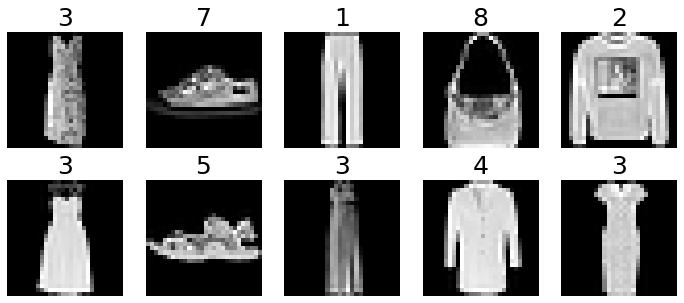

In [6]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,42000,size=10)
for i in range(10):
    axes[i].imshow(X_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [7]:
m_train = 59000
m_validation = 1000

mask = list(range(m_train, m_train + m_validation))
X_val = X_train[mask]
y_val = y_train[mask]

mask = list(range(m_train))
X_train = X_train[mask]
y_train = y_train[mask]

mask = list(range(m_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [9]:
X_train = X_train.reshape(m_train, -1)
X_val = X_val.reshape(m_validation, -1)
X_test = X_test.reshape(m_test, -1)


In [10]:
class TwoLayerNet(object):
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        self.params = {}    
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)   
        self.params['b1'] = np.zeros((1, hidden_size))    
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)   
        self.params['b2'] = np.zeros((1, output_size))
    def loss(self, X, y=None, reg=0.0):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape
        
        # Compute the forward pass
        scores = None
        h1 = ReLU(np.dot(X, W1) + b1)      
        out = np.dot(h1, W2) + b2          
        scores = out
        
        # If the targets are not given then jump out, we're done
        if y is None:   
            return scores
        
        # Compute the loss
        scores_max = np.max(scores, axis=1, keepdims=True)    # (N,1)
        exp_scores = np.exp(scores - scores_max)              # (N,C)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)    # (N,C)
        correct_logprobs = -np.log(probs[range(N), y])        # (N,1)
        data_loss = np.sum(correct_logprobs) / N
        reg_loss = 0.5 * reg * np.sum(W1*W1) + 0.5 * reg * np.sum(W2*W2)
        loss = data_loss + reg_loss
        
        # Backward pass: compute gradients
        grads = {}
        dscores = probs                                 # (N,C)
        dscores[range(N), y] -= 1
        dscores /= N
        dW2 = np.dot(h1.T, dscores)                     # (H,C)
        db2 = np.sum(dscores, axis=0, keepdims=True)    # (1,C)
        dh1 = np.dot(dscores, W2.T)                     # (N,H)
        dh1[h1 <= 0] = 0
        dW1 = np.dot(X.T, dh1)                          # (D,H)
        db1 = np.sum(dh1, axis=0, keepdims=True)        # (1,H)
        dW2 += reg * W2
        dW1 += reg * W1
        
        grads['W1'] = dW1
        grads['b1'] = db1
        grads['W2'] = dW2
        grads['b2'] = db2

        return loss, grads

    def train(self, X, y, X_val, y_val, learning_rate=1e-3, 
               learning_rate_decay=0.95, reg=1e-5, mu=0.9, num_epochs=10, 
               mu_increase=1.0, batch_size=200, verbose=False):   
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(int(num_train / batch_size), 1)
        
        # Use SGD to optimize the parameters in self.model
        v_W2, v_b2 = 0.0, 0.0
        v_W1, v_b1 = 0.0, 0.0
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(1, num_epochs * iterations_per_epoch + 1):   
            X_batch = None   
            y_batch = None 
            
            # Create a random minibatch of training data and labels
            sample_index = np.random.choice(num_train, batch_size, replace=True)   
            X_batch = X[sample_index, :]          
            y_batch = y[sample_index]             
            
            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg) 
            loss_history.append(loss)
            
            # Use the gradients to update the parameters of the network
            v_W2 = mu * v_W2 - learning_rate * grads['W2']    
            self.params['W2'] += v_W2   
            v_b2 = mu * v_b2 - learning_rate * grads['b2']    
            self.params['b2'] += v_b2   
            v_W1 = mu * v_W1 - learning_rate * grads['W1']    
            self.params['W1'] += v_W1   
            v_b1 = mu * v_b1 - learning_rate * grads['b1']  
            self.params['b1'] += v_b1
            
            if verbose and it % iterations_per_epoch == 0:    
            # Every epoch, check train and val accuracy and decay learning rate.
                epoch = it / iterations_per_epoch    
                train_acc = (self.predict(X_batch) == y_batch).mean()    
                val_acc = (self.predict(X_val) == y_val).mean()    
                train_acc_history.append(train_acc)    
                val_acc_history.append(val_acc)    
                print("epoch %d / %d: loss %f, train_acc: %f, val_acc: %f" % 
                                    (epoch, num_epochs, loss, train_acc, val_acc))
                
                # Decay learning rate
                learning_rate *= learning_rate_decay    
                mu *= mu_increase

        return {   
            'loss_history': loss_history,   
            'train_acc_history': train_acc_history,   
            'val_acc_history': val_acc_history,
        }

    def predict(self, X):    
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """
        y_pred = None    
        h1 = ReLU(np.dot(X, self.params['W1']) + self.params['b1'])    
        scores = np.dot(h1, self.params['W2']) + self.params['b2']    
        y_pred = np.argmax(scores, axis=1)    

        return y_pred

def ReLU(x):    
     
    return np.maximum(0, x)

In [11]:
input_size = X_train.shape[1]
hidden_size = 10
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_epochs=10, batch_size=1024,
            learning_rate=7.5e-4, learning_rate_decay=0.95,
            reg=1.0, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()

epoch 1 / 10: loss 1.439761, train_acc: 0.551758, val_acc: 0.542000
epoch 2 / 10: loss 0.860123, train_acc: 0.715820, val_acc: 0.707000
epoch 3 / 10: loss 0.716682, train_acc: 0.771484, val_acc: 0.765000
epoch 4 / 10: loss 0.672674, train_acc: 0.807617, val_acc: 0.804000
epoch 5 / 10: loss 0.675123, train_acc: 0.803711, val_acc: 0.799000
epoch 6 / 10: loss 0.609567, train_acc: 0.829102, val_acc: 0.811000
epoch 7 / 10: loss 0.627042, train_acc: 0.813477, val_acc: 0.798000
epoch 8 / 10: loss 0.612536, train_acc: 0.822266, val_acc: 0.807000
epoch 9 / 10: loss 0.616635, train_acc: 0.838867, val_acc: 0.819000
epoch 10 / 10: loss 0.654490, train_acc: 0.803711, val_acc: 0.792000


In [12]:
hidden_size = 10
num_classes = 10

results = {}
best_val = -1
best_net = None

learning_rates = np.array([2.5,5,7.5,10])*1e-4
regularization_strengths = [0.25,0.5,0.75,1]

for lr in learning_rates:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        stats = net.train(X_train, y_train, X_val, y_val,
        num_epochs=10, batch_size=1024,
        learning_rate=lr, learning_rate_decay=0.95,
        reg= reg, verbose=False)
        val_acc = (net.predict(X_val) == y_val).mean()
        if val_acc > best_val:
            best_val = val_acc
            best_net = net         
        results[(lr,reg)] = val_acc


for lr, reg in sorted(results):
    val_acc = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (
                lr, reg,  val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.500000e-04 reg 2.500000e-01 val accuracy: 0.828000
lr 2.500000e-04 reg 5.000000e-01 val accuracy: 0.825000
lr 2.500000e-04 reg 7.500000e-01 val accuracy: 0.835000
lr 2.500000e-04 reg 1.000000e+00 val accuracy: 0.834000
lr 5.000000e-04 reg 2.500000e-01 val accuracy: 0.840000
lr 5.000000e-04 reg 5.000000e-01 val accuracy: 0.836000
lr 5.000000e-04 reg 7.500000e-01 val accuracy: 0.837000
lr 5.000000e-04 reg 1.000000e+00 val accuracy: 0.793000
lr 7.500000e-04 reg 2.500000e-01 val accuracy: 0.837000
lr 7.500000e-04 reg 5.000000e-01 val accuracy: 0.838000
lr 7.500000e-04 reg 7.500000e-01 val accuracy: 0.801000
lr 7.500000e-04 reg 1.000000e+00 val accuracy: 0.812000
lr 1.000000e-03 reg 2.500000e-01 val accuracy: 0.819000
lr 1.000000e-03 reg 5.000000e-01 val accuracy: 0.815000
lr 1.000000e-03 reg 7.500000e-01 val accuracy: 0.811000
lr 1.000000e-03 reg 1.000000e+00 val accuracy: 0.798000
best validation accuracy achieved during cross-validation: 0.840000


In [13]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.853
